# 🤗 Diffusers Walk-through

In recent months, it has become clear that diffusion models have taken the throne as the state-of-the-art generative models. Here, we will use HuggingFace's brand new [Diffusers](https://github.com/huggingface/diffusers) library to train a simple diffusion model. Hopefully it is flexible enough to allow you to also try training on your own datasets with different models.

## Installs and Imports

First you must install the Hugging Face Diffusers library. Since it is brand new, with many changes still being made daily, it is probably best to install directly from the GitHub repository.

Tools like [Accelerate](https://github.com/huggingface/accelerate), [Datasets](https://github.com/huggingface/datasets), and [Weights and Biases](https://wandb.ai) are also installed and used in this tutorial.

Let's install and import all these packages:

In [1]:
!pip install git+https://github.com/huggingface/diffusers.git > /dev/null
!pip install wandb > /dev/null
!pip install accelerate > /dev/null
!pip install datasets > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-d2dok4o6


In [2]:
import torch
import torch.nn.functional as F
import os
import math
import wandb
from accelerate import Accelerator, notebook_launcher
from diffusers import DDPMPipeline, DDPMScheduler, UNetModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from tqdm.auto import tqdm
from datasets import load_dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

## Config

Here we define our configuration. This would be similar to the arguments used for a training script. Put in your own username for Weights and Biases tracking:

In [3]:
class Config:
    size=128
    batch_size = 16
    num_to_sample = 16
    epochs = 50
    grad_accum_steps = 1
    lr=1e-4
    warmup_steps = 500
    ema_inv_gamma = 1.0
    ema_power = 0.75
    ema_max_decay = 0.9999
    save_image_freq = 20
    save_model_freq = 10
    mixed_precision = 'fp16'
    output_dir = 'diffusers_butterflies_128_ema'
    wandb = {'entity': 'tmabraham', # put your own username
             'project': 'diffusers_notebook', 
             'group': 'butterflies_128', 
             }
    
Config.tfms = transforms.Compose([
        transforms.Resize(Config.size, interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.CenterCrop(Config.size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

## Dataset loading

Here we will load our dataset using the HuggingFace Datasets library. We will use [this butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) dataset. You can replace this code section with your own dataset loading code.

In [4]:
def augs(examples):
    images = [Config.tfms(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

In [5]:
def load_your_dataset():
    dataset = load_dataset('huggan/smithsonian_butterflies_subset')
    dataset.set_transform(augs)
    return dataset['train']

In [6]:
dataset = load_your_dataset()

Using custom data configuration huggan--smithsonian_butterflies_subset-7665b1021a37404c
Reusing dataset parquet (/home/tmabraham/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

Parameter 'transform'=<function augs at 0x7f1641af7130> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

## Diffusion model setup:

Here we set up our diffusion model. Diffusion models are neural networks that model the distribution $p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t)$ (see image below), and therefore take in an noisy image and iteratively return a denoised version.

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here. Diffusers provides us a handy `UnetModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size:

In [8]:
model = UNetModel(resolution=Config.size)

Let's get a sample image from our dataset (need to add a batch dimension) and pass it into our model:

In [9]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [10]:
print('Output shape:', model(sample_image,timesteps=0).shape)

Output shape: torch.Size([1, 3, 128, 128])


We confirm that passing in our 128x128 image results in an output of the same size.

Note that our model takes in the (noisy) image and also the current time-step. That time-step information is specified in the model using a sinusoidal positional embedding (like in Transformers). You can see that in the code over [here](https://github.com/huggingface/diffusers/blob/abedfb08f18c37d620ebd64f77db7ce89a7454b4/src/diffusers/models/resnet.py#L352). 

Schedulers are the algorithms to use diffusion models in training for inferenc. They include the noise schedules and define algorithm-specific diffusion steps. Different schedulers are available in HuggingFace Diffusers, and here we are going to use `DDPMScheduler` which corresponds to [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [11]:
noise_scheduler = DDPMScheduler(timesteps=1000, tensor_format="pt")

Let's show how this noise schedule works:

In [12]:
print(noise_scheduler.timesteps)

1000


You can see the variance of the noise keeps growing as the timestep increases:

In [13]:
[noise_scheduler.get_variance(t) for t in range(noise_scheduler.timesteps)][::100]

[tensor(1.0000e-20, dtype=torch.float64),
 tensor(0.0021),
 tensor(0.0041),
 tensor(0.0061),
 tensor(0.0081),
 tensor(0.0101),
 tensor(0.0120),
 tensor(0.0140),
 tensor(0.0160),
 tensor(0.0180)]

The noise scheduler can handle the final calculation of the noisy image given a specific timestep as we see here. This is basically conducting the "forward diffusion process" for the model:

In [14]:
noisy_image = noise_scheduler.add_noise(sample_image, torch.randn(sample_image.shape), torch.LongTensor([50])) # forward diffusion process

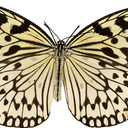

In [15]:
Image.fromarray(((sample_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

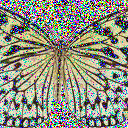

In [16]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## Training functions:

Let's use a standard AdamW optimizer and cosine learning rate schedule:

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr)

In [18]:
lr_scheduler = get_scheduler("cosine",
    optimizer=optimizer,
    num_warmup_steps=Config.warmup_steps,
    num_training_steps=(len(train_dataloader) * Config.epochs) // Config.grad_accum_steps,
)

Here is our training function. Here are some essential details:

* We use `Accelerator` from the HuggingFace Accelerate package to deal automatically with any advanced training tricks like multi-GPU training, gradient accumulation, mixed precision, etc.

* We use an exponentially-moving average (EMA) of the model since EMA model samples are much higher visual quality than base model samples.

* We use Weights and Biases to handle experiment tracking.


In [19]:
def train(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator()
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    ema_model = EMAModel(model, inv_gamma=Config.ema_inv_gamma, power=Config.ema_power, max_value=Config.ema_max_decay)
    
    use_wandb = accelerator.is_main_process and (Config.wandb is not None)
    if use_wandb:
        config = {k:v for k,v in vars(Config).items() if k[:2]!='__'}
        wandb.init(project=Config.wandb['project'], entity=Config.wandb['entity'], group=Config.wandb['group'], config=config, save_code=True)
        wandb.watch(model)
        
    for epoch in range(Config.epochs):
        train_loop(epoch, accelerator, model, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb)
        eval_loop(epoch, accelerator, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb)
        
    if use_wandb: wandb.finish()

Here is the actual training loop. 

The training is as simple as generating some random noise to add to the original image at some random time-step, predict that noise with our model, and then use the difference between the predicted noise and actual noise to update the model.

In [20]:
def train_loop(epoch, accelerator, model, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb):
    for i,batch in enumerate(tqdm(train_dataloader, disable=not accelerator.is_main_process)):
        x_0 = batch['images']
        eps = torch.randn(x_0.shape).to(x_0.device)
        bs = x_0.shape[0]
        t = torch.randint(0, noise_scheduler.timesteps, (bs,), device=x_0.device).long()
        x_t = noise_scheduler.add_noise(x_0, eps, t)
        
        if i % Config.grad_accum_steps != 0:
            with accelerator.no_sync(model):
                eps_pred = model(x_t, t)
                # predict the noise residual
                loss = F.mse_loss(eps_pred, eps)
                loss = loss / Config.grad_accum_steps
                accelerator.backward(loss)
        else:
            eps_pred = model(x_t, t)
            # predict the noise residual
            loss = F.mse_loss(eps_pred, eps)
            loss = loss / Config.grad_accum_steps
            accelerator.backward(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            ema_model.step(model)
            optimizer.zero_grad()
        
        if use_wandb:
            num_steps = len(train_dataloader)*epoch + i
            wandb.log({'loss': loss.detach().item(), 'lr': optimizer.param_groups[0]["lr"]}, step=num_steps)

Here we have our evaluation loop. Diffusers has a `DiffusionPipeline` class, where you can pass in a model and scheduler to directly generate samples in a few lines of code. That is being demonstrated here, where we use `DDPMPipeline` to generate a batch of sample images and save it as a grid to the disk and to Weights and Biases. Additionally, the Pipeline itself can be saved.

In [21]:
def eval_loop(epoch, accelerator, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb):
    if accelerator.is_main_process:
        pipeline = DDPMPipeline(unet=accelerator.unwrap_model(ema_model.averaged_model), noise_scheduler=noise_scheduler)
        if epoch % Config.save_image_freq == 0 or epoch == (Config.epochs-1):
            with torch.no_grad():
                image_batch = pipeline(batch_size = Config.num_to_sample, generator=torch.manual_seed(999))
            image = make_grid(image_batch,nrow=math.ceil(Config.num_to_sample**0.5), padding=0)
            image_processed = image.cpu().permute(1,2,0)
            image_processed = (image_processed + 1.0) * 127.5
            image_processed = image_processed.type(torch.uint8).numpy()
            image_pil = Image.fromarray(image_processed)

           # save image
            test_dir = os.path.join(Config.output_dir, "samples")
            os.makedirs(test_dir, exist_ok=True)
            filename=f"{test_dir}/{epoch:04d}.png"
            image_pil.save(filename)
            if use_wandb: wandb.log({'demo_grid': wandb.Image(filename)})
        
        if epoch % Config.save_model_freq == 0:
            pipeline.save_pretrained(f"{Config.output_dir}/{epoch:04d}") 
            if use_wandb: wandb.save(f"{Config.output_dir}/{epoch:04d}/*")
            

Here we can launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [22]:
notebook_launcher(train, \
                  (model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), \
                  mixed_precision=Config.mixed_precision, \
                  num_processes=1)


Launching training on one GPU.


wandb: Currently logged in as: tmabraham. Use `wandb login --relogin` to force relogin


  0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.85it/s]
wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.78it/s]
wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.79it/s]
wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.80it/s]


loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▂▃▅▅▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
loss,0.00703
lr,0.0


Let's see the final image grid produced by our trained diffusion model:

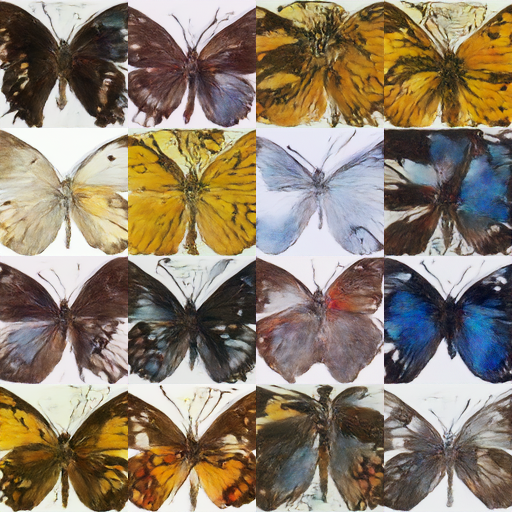

In [23]:
test_dir = os.path.join(Config.output_dir,'samples')
Image.open(os.path.join(test_dir,sorted(os.listdir(test_dir))[-1]))